# Importando bibliotecas

In [1]:
from protendido import obj_ic_jack_priscilla, new_obj_ic_jack_priscilla
from metapy_toolbox import metaheuristic_optimizer
from easyplot_toolbox import line_chart, histogram_chart, scatter_chart, bar_chart
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# Dados gerais inseridos pelos usuários

In [2]:
# Presstressed beam parameters
g_ext = 10.75       # Nome no Streamlit: Carga externa permanente (kN/m)
q = 5.00            # Nome no Streamlit: Carga variável de utilização (kN/m)
l = 12              # Nome no Streamlit: Vão da viga (m)
f_c = 30.00         # Nome no Streamlit: Resistência característica à compressão no serviço (MPa) 
f_cj = 24.56        # Nome no Streamlit: Resistência característica à compressão no ato (MPa)
phi_a = 2.00        # Nome no Streamlit: Coeficiente de fluência para carregamento no ato
phi_b = 1.50        # Nome no Streamlit: Coeficiente de fluência para carregamento no serviço
psi = 0.60          # Nome no Streamlit: Coeficiente ψ redutor para ação variável
perda_inicial = 5   # Nome no Streamlit: Estimativa pecentual da perda inicial de protensão (%)
perda_final = 20    # Nome no Streamlit: Estimativa pecentual da perda total de protensão (%)

# Algorithm parameters
iterations = 50     # Nome no Streamlit: Número de iterações do otimizador
pop_size = 30       # Nome no Streamlit: Número de agentes para busca
n_lambda = 20       # Isso aqui vamos usar sempre 20, o usuário não vai poder editar vai ser "variável de ambiente" nossa  
n_length = 20000    # Isso aqui vamos usar sempre 20000, o usuário não vai poder editar vai ser "variável de ambiente" nossa  
pres_min = 100      # Nome no Streamlit: Carga de protensão (kN) - valor inferior
pres_max = 1000     # Nome no Streamlit: Carga de protensão (kN) - valor superior
exc_min = 0.10      # Nome no Streamlit: Excentricidade de protensão (m) - valor inferior
exc_max = 1.00      # Nome no Streamlit: Excentricidade de protensão (m) - valor superior
width_min = 0.14    # Nome no Streamlit: Largura da seção (m) - valor inferior
width_max = 2.00    # Nome no Streamlit: Largura da seção (m) - valor superior
height_min = 0.14   # Nome no Streamlit: Altura da seção (m) - valor inferior
height_max = 2.00   # Nome no Streamlit: Altura da seção (m) - valor superior

# Execução método de Monte Carlo

In [3]:
p = [pres_min, pres_max]
e_p = [exc_min, exc_max]
bw = [width_min, width_max]
h = [height_min, height_max]
n = n_length

np.random.seed(42)
p_samples = list(np.random.uniform(p[0], p[1], n))
e_p_samples = list(np.random.uniform(e_p[0], e_p[1], n))
bw_samples = list(np.random.uniform(bw[0], bw[1], n))
h_samples = list(np.random.uniform(h[0], h[1], n))

df = {'p (kN)': p_samples, 'e_p (m)': e_p_samples, 'bw (m)': bw_samples, 'h (m)': h_samples}
df = pd.DataFrame(df)
df.head()

,p (kN),e_p (m),bw (m),h (m)
0,437.086107,0.756998,0.695976,1.519293
1,955.642876,0.266061,0.316361,1.778849
2,758.794548,0.411976,0.375028,1.001515
3,638.792636,0.696953,0.476048,0.677872
4,240.416776,0.533880,0.518795,0.733055


In [4]:
a_c_list = []
r_list = []
rig_list = []
g_lists = []

for i, row in df.iterrows():
    fixed_variables = {
                        'g (kN/m)': g_ext,
                        'q (kN/m)': q,
                        'l (m)': l,
                        'tipo de seção': 'retangular',
                        'fck,ato (kPa)': f_cj * 1E3,
                        'fck (kPa)': f_c * 1E3,
                        'fator de fluência para o ato': phi_a,
                        'fator de fluência para o serviço': phi_b,
                        'flecha limite de fabrica (m)': l/1000,
                        'flecha limite de serviço (m)': l/250,
                        'coeficiente parcial para carga q': psi,
                        'perda inicial de protensão (%)': perda_inicial,
                        'perda total de protensão (%)': perda_final
                        }

    of, g = new_obj_ic_jack_priscilla([row['p (kN)'], row['e_p (m)'], row['bw (m)'], row['h (m)']], fixed_variables)
    a_c_list.append(of[0])
    r_list.append(of[1])
    g_lists.append(g)

df['a_c (m²)'] = a_c_list
df['r'] = r_list

for idx, g_list in enumerate(zip(*g_lists)):
    df[f'g_{idx}'] = g_list

df = pd.DataFrame(df)
df = df[(df[[col for col in df.columns if col.startswith('g_')]] <= 0).all(axis=1)]
df.reset_index(drop=True, inplace=True)
df.head()

,p (kN),e_p (m),bw (m),h (m),a_c (m²),r,g_0,g_1,g_2,g_3,g_4,g_5,g_6,g_7,g_8,g_9,g_10,g_11,g_12,g_13,g_14,g_15,g_16,g_17
0,955.642876,0.266061,0.316361,1.778849,0.562759,0.569142,-0.901124,-1.558852,-0.989411,-1.059849,-0.892436,-1.607953,-0.804149,-2.106956,-1.658327e+12,-0.945473,-0.824747,-3.154558e+13,-0.977245,-0.982248,-0.667624,-0.703525,-0.644308,-0.241373
1,737.265320,0.307310,0.714515,1.768348,1.263511,0.297303,-0.912703,-1.493406,-1.001515,-0.991440,-1.016361,-0.907525,-0.927550,-1.409491,-1.142583e+13,-0.624310,-0.879469,-2.169552e+13,-0.955527,-0.964635,-0.613814,-0.705275,-0.191884,-0.664108
2,279.706404,0.234181,0.625662,1.412714,0.883882,0.110786,-0.888727,-1.628917,-0.999896,-1.000587,-1.072802,-0.588519,-0.961633,-1.216850,-2.545025e+13,-0.163176,-0.827668,-3.101981e+13,-0.889484,-0.915336,-0.631630,-0.764548,-0.114241,-0.616406
3,380.539968,0.382328,0.625590,1.961348,1.226999,0.195120,-0.923125,-1.434503,-1.003197,-0.981931,-1.039172,-0.778596,-0.959100,-1.231168,-1.401536e+13,-0.539164,-0.891812,-1.947380e+13,-0.951618,-0.964819,-0.566820,-0.673109,-0.362082,-0.616362
4,276.384576,0.229283,0.365299,1.691261,0.617816,0.134396,-0.902067,-1.553522,-0.994926,-1.028677,-1.043549,-0.753860,-0.950689,-1.278706,-2.303752e+13,-0.242509,-0.828272,-3.091101e+13,-0.930598,-0.935945,-0.698735,-0.718123,-0.568016,-0.343004


In [5]:
ac_min = float(df['a_c (m²)'].min())
ac_max = float(df['a_c (m²)'].max())

# Execução do Algoritmo Genético

In [ ]:
import pandas as pd
lambda_list = list(np.linspace(ac_min, ac_max, n_lambda))
results = []
iter_var = 0

for lambda_value in lambda_list:
    print(f'Iteration: {iter_var}, Lambda: {lambda_value}')

    variaveis_proj = {
                            'g (kN/m)': g_ext,
                            'q (kN/m)': q,
                            'l (m)': l,
                            'tipo de seção': 'retangular',
                            'fck,ato (kPa)': f_cj * 1E3,
                            'fck (kPa)': f_c * 1E3,
                            'lambda': lambda_value,
                            'rp': 1E6,
                            'fator de fluência para o ato': phi_a,
                            'fator de fluência para o serviço': phi_b,
                            'flecha limite de fabrica (m)': l/1000,
                            'flecha limite de serviço (m)': l/250,
                            'coeficiente parcial para carga q': psi,
                            'perda inicial de protensão (%)': perda_inicial,
                            'perda total de protensão (%)': perda_final
                        }
    algorithm_setup = {   
                            'number of iterations': iterations,
                            'number of population': pop_size,
                            'number of dimensions': 4,
                            'x pop lower limit': [pres_min, exc_min, width_min, height_min],
                            'x pop upper limit': [pres_max, exc_max, width_max, height_max],
                            'none variable': variaveis_proj,
                            'objective function': obj_ic_jack_priscilla,
                            'algorithm parameters': {
                                                    'selection': {'type': 'roulette'},
                                                    'crossover': {'crossover rate (%)': 90, 'type':'linear'},
                                                    'mutation': {'mutation rate (%)': 20, 'type': 'hill climbing', 'cov (%)': 10, 'pdf': 'gaussian'},
                                                    }
                      }

    general_setup = {   
                        'number of repetitions': 5,
                        'type code': 'real code',
                        'initial pop. seed': [None] * 15,
                        'algorithm': 'genetic_algorithm_01',
                    }
    
    df_all_reps, df_resume_all_reps, reports, status = metaheuristic_optimizer(algorithm_setup, general_setup)
    best_result_row = df_resume_all_reps[status].iloc[-1]
    of, g = new_obj_ic_jack_priscilla([best_result_row['X_0_BEST'], 
                                       best_result_row['X_1_BEST'], 
                                       best_result_row['X_2_BEST'], 
                                       best_result_row['X_3_BEST']], 
                                       variaveis_proj)
    result = {
                'lambda': lambda_value,
                'X_0_BEST': best_result_row['X_0_BEST'],
                'X_1_BEST': best_result_row['X_1_BEST'],
                'X_2_BEST': best_result_row['X_2_BEST'],
                'X_3_BEST': best_result_row['X_3_BEST'],
                'OF_0': of[0],
                'OF_1': of[1]
            }
    for i, g_value in enumerate(g):
        result[f'G_{i}'] = g_value
    iter_var += 1
    results.append(result)
df_results = pd.DataFrame(results)

Iteration: 0, Lambda: 0.2378466267062841
 Optimization results: 

 - Best repetition id:    5
 - Best of:               -8.2959474964e-01
 - Design variables:      [887.456176448862, 0.2810781033712299, 0.2428825081504356, 0.9806511053562109]
 - Process time (s):      30.043610
 - Best process time (s): 0.313355

Iteration: 1, Lambda: 0.32752948625987166
 Optimization results: 

 - Best repetition id:    6
 - Best of:               -8.8740270095e-01
 - Design variables:      [806.205298399986, 0.3747954735434613, 0.31317181036762787, 1.043102713333608]
 - Process time (s):      29.408870
 - Best process time (s): 0.195668

Iteration: 2, Lambda: 0.4172123458134592
 Optimization results: 

 - Best repetition id:    4
 - Best of:               -9.0595816677e-01
 - Design variables:      [883.6824626241826, 0.3904149521183343, 0.41515923540134425, 1.0026430089094722]
 - Process time (s):      28.901473
 - Best process time (s): 0.304498

Iteration: 3, Lambda: 0.5068952053670467
 Optimizati

In [7]:
#df_results.to_excel('results.xlsx', index=False)
df_results

,lambda,X_0_BEST,X_1_BEST,X_2_BEST,X_3_BEST,OF_0,OF_1,G_0,G_1,G_2,G_3,G_4,G_5,G_6,G_7,G_8,G_9,G_10,G_11,G_12,G_13,G_14,G_15,G_16,G_17
0,0.237847,887.456176,0.281078,0.242883,0.980651,0.238183,0.829595,-1.002858,-0.983848,-1.163006,-0.078683,-0.544186,-3.576276,-0.384038,-4.481441,-1.934135e+12,-0.936404,-0.624940,-6.751072e+13,-0.445491,-1.050790,-0.363058,-0.836558,-0.504651,-0.011868
1,0.327529,806.205298,0.374795,0.313172,1.043103,0.326670,0.887403,-1.022831,-0.870958,-1.173391,-0.019986,-0.677145,-2.824788,-0.526585,-3.675760,-9.260075e+11,-0.969552,-0.753545,-4.436188e+13,-0.596971,-1.055573,-0.201537,-0.826150,-0.399538,-0.233647
2,0.417212,883.682463,0.390415,0.415159,1.002643,0.416257,0.905958,-1.015803,-0.910683,-1.172438,-0.025372,-0.726117,-2.547997,-0.569481,-3.433308,-1.816589e+11,-0.994027,-0.791416,-3.754519e+13,-0.637876,-1.057100,-0.134698,-0.832893,-0.171870,-0.421909
3,0.506895,524.600885,0.706087,0.261978,1.938343,0.507804,0.877734,-0.993429,-1.037138,-1.074452,-0.579195,-0.880981,-1.672698,-0.799959,-2.130642,-5.538279e+10,-0.998179,-0.898680,-1.823756e+13,-0.923597,-1.011013,-0.190503,-0.676943,-0.729688,-0.083893
4,0.596578,799.784857,0.534847,0.501912,1.188551,0.596548,0.926000,-1.006401,-0.963819,-1.138537,-0.216984,-0.830614,-1.957378,-0.698478,-2.704213,-8.150126e+09,-0.999732,-0.868865,-2.360426e+13,-0.803581,-1.036655,-0.000002,-0.801908,-0.155422,-0.521828
5,0.686261,614.383411,0.749770,0.411344,1.666391,0.685461,0.917701,-0.998352,-1.009315,-1.092597,-0.476636,-0.892686,-1.606544,-0.798440,-2.139223,-2.261825e+10,-0.999256,-0.912235,-1.579762e+13,-0.912641,-1.016427,-0.000141,-0.722268,-0.506305,-0.416547
6,0.775944,726.916205,0.680220,0.512732,1.511865,0.775182,0.911735,-0.992994,-1.039599,-1.096872,-0.452475,-0.893007,-1.604727,-0.789129,-2.191851,-9.204558e+08,-0.999970,-0.908305,-1.650509e+13,-0.905446,-1.018001,-0.000176,-0.748023,-0.321722,-0.531919
7,0.865627,731.837337,0.720972,0.539039,1.604020,0.864630,0.905680,-0.989392,-1.059959,-1.087302,-0.506567,-0.907711,-1.521621,-0.809801,-2.075012,-4.144965e+09,-0.999864,-0.917216,-1.490109e+13,-0.924315,-1.014524,-0.001159,-0.732663,-0.327889,-0.554763
8,0.955310,733.621459,0.765244,0.561255,1.700621,0.954481,0.901099,-0.987068,-1.073091,-1.079417,-0.551134,-0.919494,-1.455025,-0.827145,-1.976982,-6.467807e+07,-0.999998,-0.924847,-1.352756e+13,-0.938580,-1.011918,-0.000046,-0.716563,-0.339942,-0.572387
9,1.044992,835.640736,0.712103,0.660159,1.582629,1.044788,0.896645,-0.983399,-1.093827,-1.082633,-0.532956,-0.919368,-1.455734,-0.820135,-2.016605,-1.147404e+09,-0.999962,-0.921789,-1.407796e+13,-0.934839,-1.012758,-0.000113,-0.736228,-0.165744,-0.636451


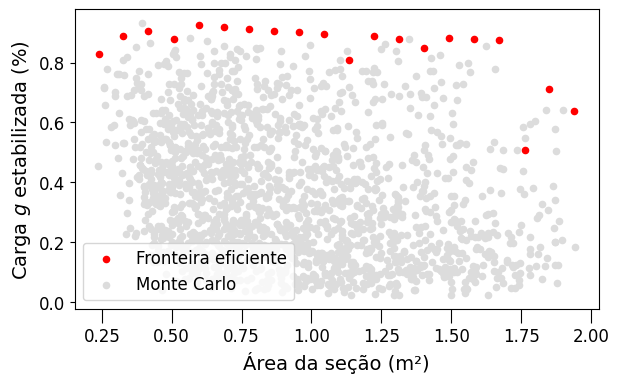

In [15]:
# Data
df_new = { 
        'x0': df_results['OF_0'],
        'y0': df_results['OF_1'],
        'x1': df['a_c (m²)'],
        'y1': df['r'],
     }
# Chart setup
chart_config = {
                'name': 'figure1-3-1',
                'width': 16, 
                'height': 10,
                'dots_per_inch': 600, 
                'extension': 'svg',
                'marker_size': 20,
                'color_map': ['red', '#dcdcdc'],
                'x_axis_label': 'Área da seção (m²)',
                'x_axis_size': 12,
                'y_axis_label': 'Carga $g$ estabilizada (%)',
                'y_axis_size': 12,
                'axises_color': 'black', 
                'labels_size': 14,
                'labels_color': 'black',
                'on_grid': False,
                'y_log': False,
                'x_log': False,
                'legend': ['Fronteira eficiente', 'Monte Carlo'],
                'legend_location': 'lower left',
                'size_legend': 12,
               }

# Call function
scatter_chart(dataset=df_new, plot_setup=chart_config)